In [16]:
# Cell 1: Import Libraries
import pandas as pd
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Embedding, LSTM
from keras.optimizers import Adam
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences




In [17]:
# Cell 2: Define Constants
IMG_SIZE = 128  # Size to which images will be resized
MAX_SEQUENCE_LENGTH = 50  # Max length of the recipes


In [18]:
# Cell 3: Load and Preprocess Data
# Load the merged CSV file
data = pd.read_csv('merged_recipes_with_images.csv')

# Prepare a dictionary to hold images for each recipe
recipe_images = {}

# Iterate through the data to group images by recipes
for index, row in data.iterrows():
    recipe = row['Recipe']  # Adjust based on your CSV column name
    images = row['Image Paths'].split(', ')  # Update to use the correct column name

    if recipe not in recipe_images:
        recipe_images[recipe] = []
    recipe_images[recipe].extend(images)

# Prepare dataset for CNN
X_images = []
y_recipes = []

for recipe, images in recipe_images.items():
    for image_path in images:
        img = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = img_to_array(img) / 255.0  # Normalize the images
        X_images.append(img_array)
        y_recipes.append(recipe)

# Convert to numpy arrays
X_images = np.array(X_images)
y_recipes = np.array(y_recipes)

# Convert y_recipes to categorical labels
y_recipes_unique, y_recipes_encoded = np.unique(y_recipes, return_inverse=True)
num_classes = len(y_recipes_unique)


In [19]:
# Cell 4: Split Dataset
X_train, X_test, y_train, y_test = train_test_split(X_images, y_recipes_encoded, test_size=0.2, random_state=42)


In [20]:
# Cell 5: Build CNN Model
def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# Create the CNN model
cnn_model = create_cnn_model(X_train.shape[1:], num_classes)


c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
# Cell 6: Compile and Train the Model
cnn_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = cnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)


Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 15s 306ms/step - accuracy: 0.1208 - loss: 3.6915 - val_accuracy: 0.1968 - val_loss: 2.0476
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 291ms/step - accuracy: 0.2646 - loss: 1.9478 - val_accuracy: 0.3452 - val_loss: 1.8219
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 298ms/step - accuracy: 0.4404 - loss: 1.5694 - val_accuracy: 0.3516 - val_loss: 1.6647
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 288ms/step - accuracy: 0.5775 - loss: 1.2430 - val_accuracy: 0.4097 - val_loss: 1.6730
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 294ms/step - accuracy: 0.7342 - loss: 0.8421 - val_accuracy: 0.4065 - val_loss: 1.8637
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 293ms/step - accuracy: 0.8785 - loss: 0.4671 - val_accuracy: 0.4226 - val_loss: 1.8940
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 295ms/step - accuracy: 0.9430 - loss: 0.2277 - val_accuracy: 0.4323 - val_loss: 2.1948
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 287ms/step - accuracy: 0.9706 - loss: 0.1245 - val_accu

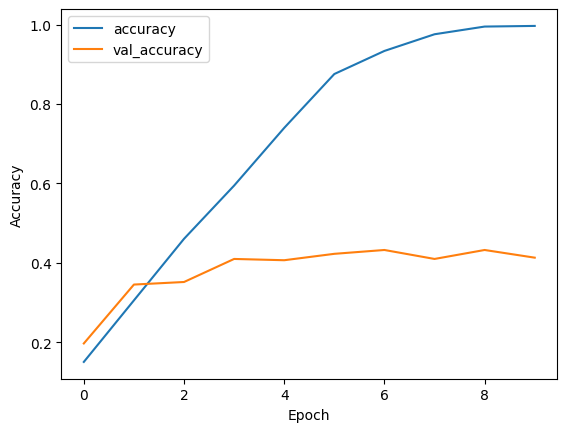

In [22]:
# Cell 7: Plot Training History
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [23]:
# Cell 8: Save the Model
cnn_model.save('cnn_model.h5')


In [32]:


# Load your data
data = pd.read_csv('merged_recipes_with_images.csv')

# Assuming the column with recipes is named 'Recipe'
recipes = data['Recipe'].values  # Make sure this column exists in your CSV

# Initialize the Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(recipes)

# Get the vocabulary size (+1 for padding token)
vocab_size = len(tokenizer.word_index) + 1  

# Set the maximum sequence length (can be adjusted based on your data)
max_sequence_length = 50  

# Convert recipes to sequences of integers
sequences = tokenizer.texts_to_sequences(recipes)

# Pad the sequences to ensure they all have the same length
sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Prepare the target variable (y_recipes_lstm)
# Assuming y_recipes_lstm should be the labels shifted by one word
# y_recipes_lstm should represent the next word to predict
# It will take the sequences and use all but the first element as the target
y_recipes_lstm = np.array([seq[1:] for seq in sequences])  # Target is the sequence shifted by one
y_recipes_lstm = np.eye(vocab_size)[y_recipes_lstm]  # Convert to one-hot encoding

# Reshape y_recipes_lstm to match the expected shape
# This ensures that the shape is (samples, timesteps, features)
y_recipes_lstm = y_recipes_lstm.reshape(-1, max_sequence_length - 1, vocab_size)  # Adjusting timesteps


In [33]:
# Cell 10: Build LSTM Model
def create_lstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim=num_classes, output_dim=128, input_length=input_shape[1]))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# Create the LSTM model
lstm_model = create_lstm_model(sequences.shape, len(tokenizer.word_index) + 1)


c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [39]:
# Load the merged CSV file
data = pd.read_csv('merged_recipes_with_images.csv')

# Prepare a dictionary to hold images and recipes
recipe_images = {}
recipe_texts = {}

# Iterate through the data to group images by recipes and collect recipe texts
for index, row in data.iterrows():
    recipe = row['Recipe']  # Adjust based on your CSV column name
    images = row['Image Paths'].split(', ')  # Adjust based on your CSV column name
    recipe_text = row['Recipe']  # Assuming you have a column for recipe text

    # Store images
    if recipe not in recipe_images:
        recipe_images[recipe] = []
    recipe_images[recipe].extend(images)

    # Store recipe text
    recipe_texts[recipe] = recipe_text


In [41]:
# Prepare the tokenizer for the recipe texts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(recipe_texts.values())  # Fit tokenizer on all recipe texts

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(recipe_texts.values())

# Pad the sequences to ensure uniform input size
sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Convert the sequences to the format required for LSTM
# Use the previous sequences as input and the next word as the target
X_recipes = []
y_recipes_lstm = []

for seq in sequences:
    for i in range(1, len(seq)):
        X_recipes.append(seq[:i])  # Previous words
        y_recipes_lstm.append(seq[i])  # Next word

# Pad the sequences for LSTM input
X_recipes = pad_sequences(X_recipes, maxlen=MAX_SEQUENCE_LENGTH)

# Convert to numpy arrays
X_recipes = np.array(X_recipes)
y_recipes_lstm = np.array(y_recipes_lstm)

# Convert y_recipes_lstm to categorical labels
y_recipes_lstm = to_categorical(y_recipes_lstm, num_classes=len(tokenizer.word_index) + 1)


In [42]:
# Build the LSTM model
#def create_lstm_model(input_shape, num_classes):
    #model = Sequential()
    #model.add(Embedding(input_dim=num_classes, output_dim=128, input_length=input_shape[1]))
    #model.add(LSTM(128, return_sequences=True))
   # model.add(LSTM(64))
  #  model.add(Dense(num_classes, activation='softmax'))
 #   return model

# Create the LSTM model
#lstm_model = create_lstm_model(X_recipes.shape, len(tokenizer.word_index) + 1)

# Compile the model
#lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the LSTM model
#history_lstm = lstm_model.fit(X_recipes, y_recipes_lstm, validation_split=0.2, epochs=10, batch_size=32)


Epoch 1/10


c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.0127 - loss: 6.2888 - val_accuracy: 0.0225 - val_loss: 6.2310
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.0515 - loss: 6.0195 - val_accuracy: 0.0225 - val_loss: 6.0247
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.0354 - loss: 5.5049 - val_accuracy: 0.0225 - val_loss: 6.0280
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.0419 - loss: 5.1148 - val_accuracy: 0.1011 - val_loss: 6.2288
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.0682 - loss: 4.8997 - val_accuracy: 0.1011 - val_loss: 6.4093
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.0699 - loss: 4.8776 - val_accuracy: 0.1011 - val_loss: 6.5456
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.0637 - loss: 4.7880 - val_accuracy: 0.1011 - val_loss: 6.6423
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.0864 - loss: 4.8343 - val_accuracy: 0.1011 - val_loss: 6

In [53]:
from keras.layers import LSTM, Dropout

def create_lstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim=10000, output_dim=128, input_length=input_shape[1]))  # Adjust parameters as needed
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))  # Add dropout layer after LSTM
    model.add(LSTM(64))  # You can adjust this layer as necessary
    model.add(Dropout(0.5))  # Add another dropout layer
    model.add(Dense(num_classes, activation='softmax'))
    return model
 #Create the LSTM model
lstm_model = create_lstm_model(X_recipes.shape, len(tokenizer.word_index) + 1)

# Compile the model
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the LSTM model
history_lstm = lstm_model.fit(X_recipes, y_recipes_lstm, validation_split=0.2, epochs=10, batch_size=32)



Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - accuracy: 0.0110 - loss: 6.2920 - val_accuracy: 0.1011 - val_loss: 6.2703
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.0275 - loss: 6.1886 - val_accuracy: 0.0225 - val_loss: 6.1068
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.0498 - loss: 5.8714 - val_accuracy: 0.1011 - val_loss: 5.9656
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.0719 - loss: 5.4237 - val_accuracy: 0.1011 - val_loss: 6.0095
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.0476 - loss: 5.1543 - val_accuracy: 0.1011 - val_loss: 6.1946
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.0650 - loss: 5.0300 - val_accuracy: 0.1011 - val_loss: 6.3649
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.0612 - loss: 4.9748 - val_accuracy: 0.0225 - val_loss: 6.4831
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.0725 - loss: 4.9346 - val_accuracy: 0.1011 - 

In [54]:
# Save the LSTM model
lstm_model.save('lstm_model.h5')
